# Testing for Significant Vertices

In our preceding section, we learned how to estimate a signal subnetwork from a set of networks which are in one of $K$-classses, and then how to use these signal subnetworks to train a classifier which used the *signal edges* to make predictions as to the class of new networks. We learned how to use cross validation to tune the number of edges in the estimated signal subnetwork, so that we could identify the number of edges in the signal subnetwork which maximized the downstream classification accuracy for new networks. However, we had a slight problem: Even when we tuned the network using cross validation, we still missed the edge from the frontal lobe to the occipital lobe, and therefore missed a valuable opportunity to include an additional edge in our classifier. How can we rectify this? 

The problem here is that the preceding signal subnetwork estimator was an *incoherent* estimator. An **incoherent signal subnetwork estimator** is an estsimator for a signal subnetwork which does not take into consideration the structure of a network when determining the edges to include in the signal subnetwork. This is obvious from our preceding section: the signal subnetwork which is estimated looks *only* at the edges which have the highest edge importance (quantified by the edges with the lowest Fisher's exact test $p$-value) when deciding which edges to include, or exclude, from the signal subnetwork estimator. This is an incoherent estimator because it disregards the structure of the network; that is, a collection of not just edges, but also, *nodes* which convey information. On the other hand, we will now learn about a *coherent signal subnetwork estimator*. A **coherent signal subnetwork estimator** is an estimator of a signal subnetwork which leverages the structure of the network, by using at least two elements of its structure: nodes, edges, or other network attributes.

## Why do we need a coherent signal subnetwork estimator?

There are many possible ways in which one could produce an estimate of a signal subnetwork which uses any two elements of the network's structure. In this section, we will describe one which addresses the problem from our previous section. 

If you recall, in the previous example dataset we used, the probability matrices forr earthlings and astronauts looked like this:

In [200]:
import numpy as np

# the number of nodes
n = 5
# edge probabilities for humans are random
np.random.seed(12345)
P_hum = np.random.beta(size=n*n, a=3, b=8).reshape(n, n)
# networks are undirected, so make the probability matrix symmetric
P_hum = (P_hum + P_hum.T)/2
# networks are loopless, so remove the diagonal
P_hum = P_hum - np.diag(np.diag(P_hum))

# the names of each of the five nodes
nodenames = ["Occipital", "Frontal", "Temporal", "Frontal", "Insula"]
# the signal edges
E = np.array([[0,1,1,1,1], [1,0,0,0,0], [1,0,0,0,0], [1,0,0,0,0], [1,0,0,0,0]], dtype=bool)
P_ast = np.copy(P_hum)

# probabilities for signal edges are higher in astronauts than humans
# 2/3 root function biases them towards 1, which is higher than
# whatever they are right now since they are between 0 and 1
P_ast[E] = np.power(P_ast[E], 2/3)

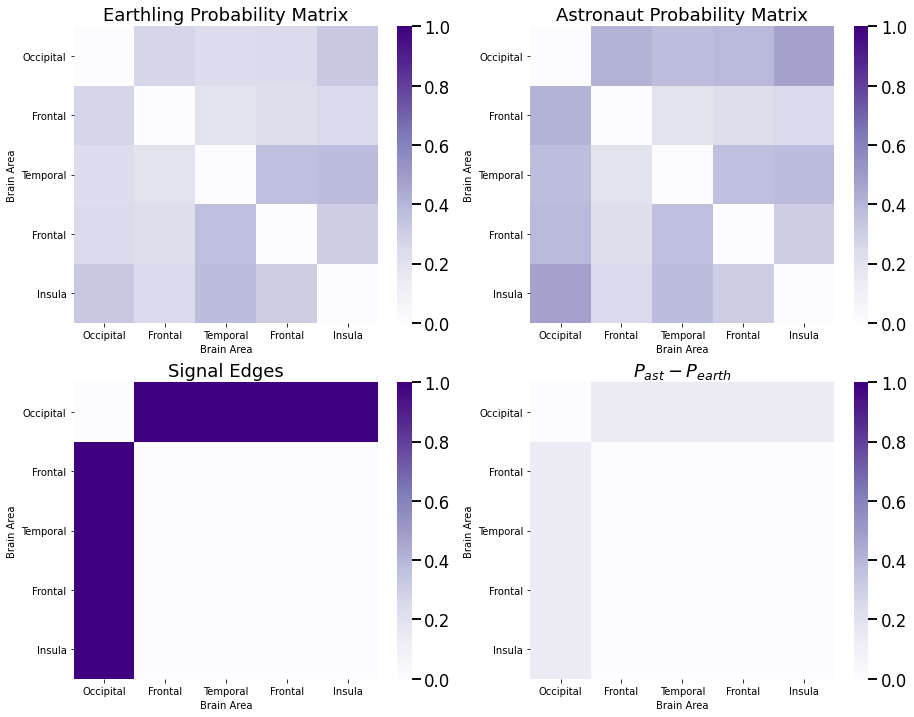

In [201]:
from matplotlib import pyplot as plt
import seaborn as sns

def plot_prob(X, title="", nodename="Brain Area", nodetix=[0.5, 1.5, 2.5, 3.5, 4.5],
             nodelabs=nodenames, ax=None, vmin=0, vmax=1):
    if (ax is None):
        fig, ax = plt.subplots(figsize=(8, 6))
    
    with sns.plotting_context("talk", font_scale=1):
        ax = sns.heatmap(X, cmap="Purples",
                        ax=ax, cbar_kws=dict(shrink=1), yticklabels=False,
                        xticklabels=False, vmin=vmin, vmax=vmax, annot=False)
        ax.set_title(title)
        cbar = ax.collections[0].colorbar
        ax.set(ylabel=nodename, xlabel=nodename)
        if (nodetix is not None) and (nodelabs is not None):
            ax.set_yticks(nodetix)
            ax.set_yticklabels(nodelabs)
            ax.set_xticks(nodetix)
            ax.set_xticklabels(nodelabs)
        cbar.ax.set_frame_on(True)
    return

fig, axs = plt.subplots(2,2, figsize=(15, 12))
plot_prob(P_hum, title="Earthling Probability Matrix", ax=axs[0,0])
plot_prob(P_ast, title="Astronaut Probability Matrix", ax=axs[0,1])
plot_prob(E, title="Signal Edges", ax=axs[1,0])
plot_prob(P_ast - P_hum, title="$P_{ast} - P_{earth}$", ax=axs[1,1])

What we saw was that the signal edges were all of the edges in which one of the nodes was the occipital lobe. We then constructed a dataset in which $200$ networks were assigned to either the earthling or the astronaut class, and then we sampled a simulated dataset using the probability matrices for each class:

In [202]:
from graphbook_code import ier

pi_ast = 0.4
pi_hum = 0.6
M = 200

# roll a 2-sided die 200 times, with probability 0.4 of landing on side 1 (astronaut) 
# and 0.6 of landing on side 2 (earthling)
np.random.seed(1234)
classnames = ["Astronaut", "Earthling"]
class_counts = np.random.multinomial(M, pvals=[pi_ast, pi_hum])
print("Number of individuals who are astronauts: {:d}".format(class_counts[0]))
print("Number of individuals who are humans: {:d}".format(class_counts[1]))

# create class assignment vector, and randomly reshuffle class labels for each individual
yvec = np.array([1 for i in range(0, class_counts[0])] + [2 for i in range(0, class_counts[1])])
np.random.seed(123456)
np.random.shuffle(yvec)

# arrange the probability matrices in a list
prob_mtxs = [P_ast, P_hum]
# initialize empty list for adjacency matrices
As = []
np.random.seed(1234)
seeds = np.random.randint(1, np.iinfo(np.int32).max, size=M)
for i, y in enumerate(yvec):
    # sample adjacency matrix for an individual of class y using the probability
    # matrix for that class
    np.random.seed(seeds[i])
    As.append(ier(prob_mtxs[y - 1], directed=False, loops=False))

# stack the adjacency matrices for each individual such that node i is first dimension,
# node j is second dimension, and the individual index m is the third dimension
As = np.stack(As, axis=2)

Number of individuals who are astronauts: 77
Number of individuals who are humans: 123


Then, we constructed a significance matrix by using the $p$-values (ranked from smallest, 1 to largest, 0) obtained by performing Fisher's exact test at each edge, where we tested whether $H_0: p_{ij}^{hum} = p_{ij}^{ast}$ the probabilities were equal between the humans and astronauts for that particular edge against $H_A: p_{ij}^{hum} \neq p_{ij}^{ast}$ that the probabilities were not equal between the humans and astronauts for that particular edge. A small $p$-value favors the alternative hypothesis that the probabilities are unequal, and therefore the edges with the lowest rank in the significance matrix are the ones for which it is likely the case that there is more signal:

In [203]:
from scipy.stats import rankdata, fisher_exact

fisher_mtx = np.zeros((n,n))
ast_idxs = yvec == 1  # the individuals who are astronauts
hum_idxs = yvec == 2  # the individuals who are earthlings
# since the networks are undirected, only need to compute for upper triangle
for i in range(0, n):
    for j in range(i+1, n):
        ast_edgeij = As[i,j,ast_idxs].sum()
        hum_edgeij = As[i,j,hum_idxs].sum()
        table = np.array([[ast_edgeij, hum_edgeij],
                          [class_counts[0] - ast_edgeij, class_counts[1] - hum_edgeij]])
        fisher_mtx[i,j] = fisher_exact(table)[1]
fisher_mtx = fisher_mtx + fisher_mtx.T  # symmetrize

sig_mtx = rankdata(np.max(fisher_mtx) - fisher_mtx).reshape(n,n)
sig_mtx = sig_mtx - np.diag(np.diag(sig_mtx))

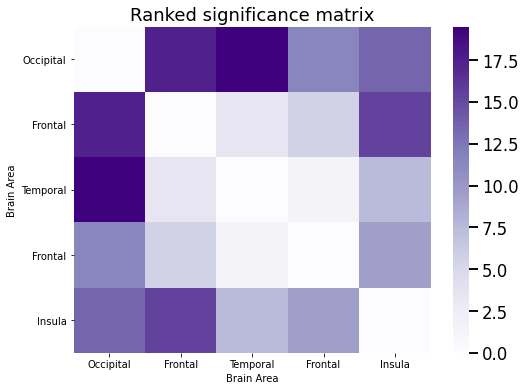

In [204]:
fig, ax = plt.subplots(1,1, figsize=(8, 6));
plot_prob(sig_mtx, title="Ranked significance matrix", vmax=sig_mtx.max(), ax=ax)

We then took the edges with the $K$-largest ranks, and called these the incoherent estimate of the signal subnetwork, $\hat S$. We then did this all with graspologic using the following code:

In [205]:
from graspologic.subgraph import SignalSubgraph

K = 8  # the number of edges in the subgraph
sgest = SignalSubgraph()
sgest.fit_transform(As, labels=yvec - 1, constraints=K);

sigsub_inco = np.zeros((n,n))  # initialize empty matrix
sigsub_inco[sgest.sigsub_] = 1

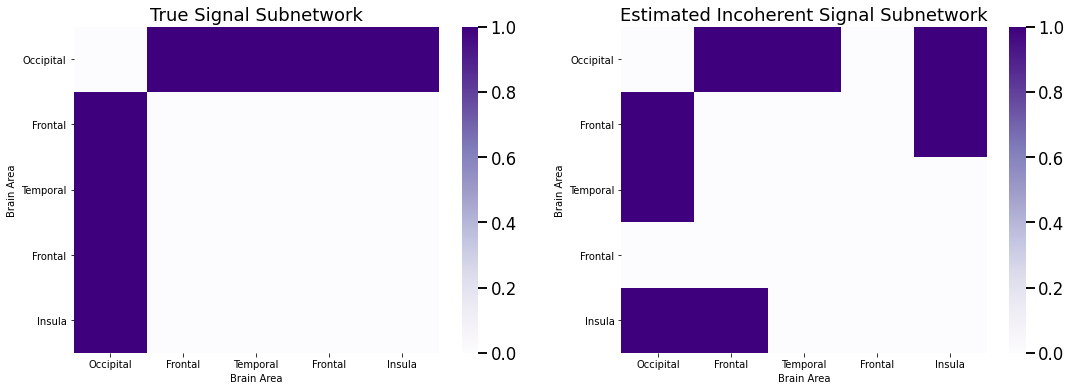

In [206]:
fig, axs = plt.subplots(1,2, figsize=(18, 6));
plot_prob(E, title="True Signal Subnetwork", ax=axs[0])
plot_prob(sigsub_inco, title="Estimated Incoherent Signal Subnetwork", ax=axs[1])

While we did a pretty good job, getting $6$ of the $8$ signal edges correct, but we missed the edges between the occipital and the frontal lobe! Why might this have occured?

When we deal with data we obtain from an experiment, like these brain networks we synthetically generated, the key is that the brain networks are realizations of random networks, like we learned in [Chapter 5](#link?). What this means is that there is always a chance that the networks we see, even if we see a lot of them, won't give us *perfect* estimate of the class probabilities for each edge, $p_{ij}^y$. Think about it this way: if we had a coin which landed on heads 60% of the time and a coin which landed on heads 40% of the time, and we flipped them each 10 times, there is a chance that the coin which landed on heads 40% of the time still landed on heads more than the other coin when we flipped both of them. When we start adding more and more coins to the mix (one for each edge in the network), the chances of at least one pair of coins not showing what we might intuitively expect becomes pretty high!

Fortunately, for our brain networks, we have another property about each edge wich we *can* use: the nodes that the edges are between. What we will do is something like this: we compute the ranked significance matrix, *exactly* as we did before. However, when we pick the edges to include, or exclude, we first choose the $L$ nodes (the *signal nodes*) which tend to have the highest ranked significances, and then we pick the $K$ signal edges using *only* edges which have at least one node as a signal node. This approach produces a coherent signal subnetwork estimate because it uses both the nodes *and* the edges when deciding the signal subnetwork estimate. 

## Building a coherent signal subnetwork estimator

The algorithmic approach for the coherent signal subnetwork estimator gets a little hairy, but we'll discuss it at a high level here. Effectively, the process is as follows. We seek to identify a signal subnetwork amongst $L$ nodes, with $K$ total signal edges:

1. We begin with the ranked significance matrix, like we did for the signal subnetwork model. 
2. Initialize $c$ at the maximim possible rank, and $w_c$ at $0$.
3. While $w_c < K$:
  * For each node $i$, compute the number of edges for the node $i$ where the rank exceeds $c$. Define this quantity to be $w_{i,c}$. In this step, we are finding nodes which have signal edges remaining at our particular chosen threshold.
  * Rank the nodes according to which node has the largest number of signal edges. The top-ranked node will be denoted $w_{(1), c}$, the second ranked node will be denoted $w_{(2), c}$, so on and so forth, to $w_{(n)}, c}$. 
  * Let $w_c$ be the sum of the number of edges each of the top $L$-ranked nodes have above the threshold $c$. That is, $w_c = \sum_{j = 1}^L w_{(j), c}$ computed in the previous step. 
  * Let $c = c - 1$.
4. Let the estimate of the coherent signal subnetwork $\hat S_{L,K}$ be the top $K$ nodes estimated from the top $L$ nodes identified in the final iteration of the above loop. 

Due to the while loop, it's not extremely fruitful to exhaustively build out the code by hand here, so we'll show you how to do it using `grasapologic` relatively simply:

In [207]:
from graspologic.subgraph import SignalSubgraph

K = 8  # the number of edges in the subnetwork
L = 1  # the number of vertices in the subnetwork
sgest_co = SignalSubgraph()
sgest_co.fit_transform(As, labels=yvec - 1, constraints=[K, L]);

Next, let's take a look at the subnetwork identified:

In [208]:
sigsub_co = np.zeros((n,n))  # initialize empty matrix
sigsub_co[sgest_co.sigsub_] = 1

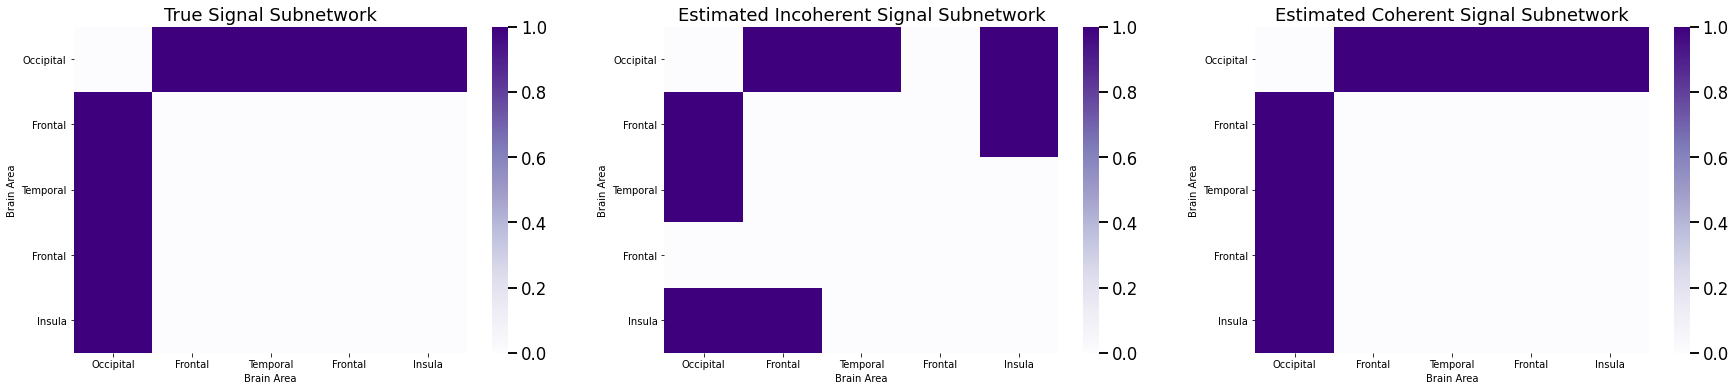

In [209]:
fig, axs = plt.subplots(1, 3, figsize=(30, 6));
plot_prob(E, title="True Signal Subnetwork", ax=axs[0])
plot_prob(sigsub_inco, title="Estimated Incoherent Signal Subnetwork", ax=axs[1])
plot_prob(sigsub_co, title="Estimated Coherent Signal Subnetwork", ax=axs[2])

And voila! We have estimated the signal subnetwork perfectly. Again, you might be thinking: how do we estimate both $L$ and $K$? The answer is, again, quite simple and very similar to what we did for the incoherent signal subnetwork, but first let's discuss how to adapt this strategy for classification.

## Classification with the Coherent Signal Subnetwork

How actually use the estimated signal subnetwork $\hat{\mathcal S}_{L, K}$ to classify new networks? Again, we can just use sklearn's `BernoulliNB` from `sklearn`, for exactly the same intuition as the preceding section. We again reorganize the output of the `SignalSubgraph` function for use with `sklearn` and train the classifier. We then create a new incoherent estimate of the signal subnetwork with $K$ edges and train an additional classifier for comparison:

In [210]:
from sklearn.naive_bayes import BernoulliNB

data = As[sgest_co.sigsub_[0], sgest_co.sigsub_[1],:].T

# the classifier trained with the coherent signal subnetwork
classifier_co = BernoulliNB()
# fit the classifier using the vector of classes for each sample
classifier_co.fit(data, yvec);


K = 8  # the number of edges in the subnetwork
sgest_inco = SignalSubgraph()
sgest_inco.fit_transform(As, labels=yvec - 1, constraints=K);

data_inco = As[sgest_inco.sigsub_[0], sgest_inco.sigsub_[1],:].T

# the classifier trained with the coherent signal subnetwork
classifier_inco = BernoulliNB()
# fit the classifier using the vector of classes for each sample
classifier_inco.fit(data_inco, yvec);

We again construct $200$ new test networks to analyze our method:

In [211]:
Mtest = 100

# roll a 2-sided die Mtest times, with probability 0.4 of landing on side 1 (astronaut) 
# and 0.6 of landing on side 2 (earthling)
np.random.seed(12345678)
class_countstest = np.random.multinomial(Mtest, pvals=[pi_ast, pi_hum])
print("Number of individuals who are astronauts: {:d}".format(class_countstest[0]))
print("Number of individuals who are humans: {:d}".format(class_countstest[1]))

# create class assignment vector, and randomly reshuffle class labels for each individual
yvectest = np.array([1 for i in range(0, class_countstest[0])] + [2 for i in range(0, class_countstest[1])])
np.random.seed(12345678)
np.random.shuffle(yvectest)

Astest = []
np.random.seed(1234)
seeds = np.random.randint(1, np.iinfo(np.int32).max, size=Mtest)
for i, y in enumerate(yvectest):
    # sample adjacency matrix for an individual of class y using the probability
    # matrix for that class
    np.random.seed(seeds[i])
    Astest.append(ier(prob_mtxs[y - 1], directed=False, loops=False))

# stack the adjacency matrices for each individual such that node i is first dimension,
# node j is second dimension, and the individual index m is the third dimension
Astest = np.stack(Astest, axis=2)


datatest_co = Astest[sgest_co.sigsub_[0], sgest_co.sigsub_[1],:].T
datatest_inco = Astest[sgest_inco.sigsub_[0], sgest_inco.sigsub_[1],:].T

predictionstest_co = classifier_co.predict(datatest_co)
predictionstest_inco = classifier_co.predict(datatest_inco)


# classifier accuracy is the fraction of predictions that are correct
acc_co = np.mean(predictionstest_co == yvectest)
print("Coherent Classifier Accuracy: {:.3f}".format(acc_co))
acc_inco = np.mean(predictionstest_inco == yvectest)
print("Incoherent Classifier Accuracy: {:.3f}".format(acc_inco))

Number of individuals who are astronauts: 40
Number of individuals who are humans: 60
Coherent Classifier Accuracy: 0.620
Incoherent Classifier Accuracy: 0.610


So our coherent estimator is doing a little better for classification than our coherent estimator. While this difference might not be particularly appreciable for our small toy dataset, when datasets grow in scale (more nodes) and the number of signal vertices is comparatively small, the coherent estimator can do a good job of pushing us towards better estimated signal subnetworks, and consequently, improve classification performance.

## Choosing the number of signal edges and the number of signal nodes

So, how do we pick $K$ and $L$, when we don't know what the number of signal edges and signal nodes are ahead of time? Again, we turn to cross validation. However, instead of just validating over the number of possible signal edges, we also check over the number of possible signal nodes. In this case, we vary the number of possible signal edges from 4 to 16, and the number of possible signal nodes from 2 to 6. Note that this code block takes quite a while to execute, so hang in there if you choose to run this code yourself:

In [212]:
from sklearn.model_selection import KFold 
kf = KFold(n_splits=20, random_state=None)

xv_res = []
max_sgsz = [8, 16, 16, 16, 16]
for k, (train_index, test_index) in enumerate(kf.split(range(0, M))):
    X_train, X_test = As[:,:,train_index], As[:,:,test_index]
    y_train = yvec[train_index]; y_test = yvec[test_index]
    
    for i, sgn in enumerate(np.arange(1, 4, step=1)):
        for sgsz in np.arange(4, max_sgsz[i] + 1, step=2):
            # estimate ssg
            sgest = SignalSubgraph()
            sgest.fit_transform(X_train, labels=y_train - 1, constraints=[int(sgsz), int(sgn)]);
            # train classifier
            data = X_train[sgest.sigsub_[0], sgest.sigsub_[1],:].T
            classifier = BernoulliNB()
            # fit the classifier using the vector of classes for each sample
            classifier.fit(data, y_train)

            datatest = X_test[sgest.sigsub_[0], sgest.sigsub_[1],:].T
            # evaluate performance on test fold        
            predictionstest = classifier.predict(datatest)

            # classifier accuracy is the fraction of predictions that are correct
            acc = np.mean(predictionstest == y_test)
            xv_res.append({"Fold": k+1, "K": sgsz, "L": sgn, "Accuracy": acc})

In [213]:
# pivot the dataframe from long to wide form
result = xv_acc.pivot_table(index='L', columns='K', values='Accuracy')

In [214]:

import pandas as pd
df_res = pd.DataFrame(xv_res)
xv_acc = df_res.groupby(['K', 'L']).agg({"Accuracy": "mean"})

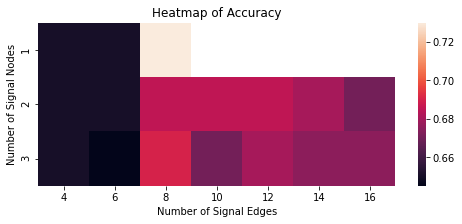

In [215]:
fig, ax = plt.subplots(1,1, figsize=(8, 3))
sns.heatmap(result, ax=ax);
ax.set_xlabel("Number of Signal Edges")
ax.set_ylabel("Number of Signal Nodes")
ax.set_title("Heatmap of Accuracy");

The hyperparameter with the highest average classification accuracy is with $1$ signal node and $8$ signal edges, which corresponds to a signal subnetwork of:

In [218]:
Khat = 8; Lhat = 1
sgest_co = SignalSubgraph()
sgest_co.fit_transform(As, labels=yvec - 1, constraints=[Khat, Lhat]);

sigsub_co = np.zeros((n,n))  # initialize empty matrix
sigsub_co[sgest_co.sigsub_] = 1

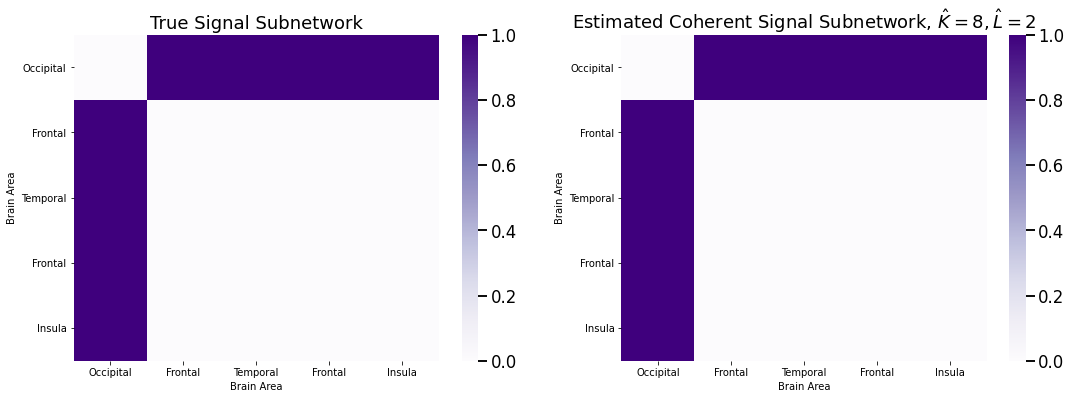

In [219]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6));
plot_prob(E, title="True Signal Subnetwork", ax=axs[0])
plot_prob(sigsub_co, title="Estimated Coherent Signal Subnetwork, $\\hat K = 8, \\hat L = 2$",
          ax=axs[1])

Which perfectly estimates the signal subnetwork.